<a href="https://colab.research.google.com/github/juan051811-beep/pro/blob/main/ACCIONES_HUMANAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DESCARGA DEL DATASET UCF101

In [ ]:
#JUAN DE DIOS COCOLETZI MUSITO
#JOEL ROJAS JIMENEZ

import kagglehub

# Download latest version
path = kagglehub.dataset_download("matthewjansen/ucf101-action-recognition")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'ucf101-action-recognition' dataset.
Path to dataset files: /kaggle/input/ucf101-action-recognition


IMPORTS

In [ ]:
import os
import cv2
import numpy as np
import random
import tensorflow as tf

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from IPython.display import HTML
from base64 import b64encode


In [ ]:
DATASET_PATH = "/root/.cache/kagglehub/datasets/matthewjansen/ucf101-action-recognition/versions/4"

TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH   = os.path.join(DATASET_PATH, "val")
TEST_PATH  = os.path.join(DATASET_PATH, "test")

#las 5 clases que seleccionamos de las 101 que hay
SELECTED_CLASSES = [
    "PlayingPiano",
    "JumpingJack",
    "PushUps",
    "BodyWeightSquats",
    "ApplyLipstick"
]

IMG_SIZE = 112 #tamaño al que se redimensionan todos los frames
FRAMES_PER_VIDEO = 8 #definimos cuantos frames se extraen de cada video
BATCH_SIZE = 2 #tamaño del batch para el entrenamiento
EPOCHS = 5 #numero de epocas de entrenamiento


In [ ]:
def extract_frames(video_path): #definimos una funcion para extraer frames de un video dado su path
    cap = cv2.VideoCapture(video_path) #abrimos el video usando opencv
    frames = [] #creamos una lista vacia donde guardaremos los frames seleccionados

    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) #obtenemos el numero total de frames del video
    if total == 0: #verificamos si el video no tiene frames
        cap.release() #liberamos el recurso del video
        return None #regresamos none para indicar que el video no es util

    step = max(total // FRAMES_PER_VIDEO, 1) #calculamos cada cuantos frames vamos a muestrear
    count = 0 #contador para llevar el numero de frames leidos

    while cap.isOpened() and len(frames) < FRAMES_PER_VIDEO: #leemos el video mientras este abierto y no tengamos suficientes frames
        ret, frame = cap.read() #leemos un frame del video
        if not ret: #si no se pudo leer el frame
            break #salimos del ciclo

        if count % step == 0: #verificamos si este frame corresponde al muestreo uniforme
            frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE)) #redimensionamos el frame al tamaño definido
            frame = frame / 255.0 #normalizamos los valores de los pixeles a rango 0-1
            frames.append(frame) #agregamos el frame a la lista

        count += 1 #incrementamos el contador de frames leidos

    cap.release() #liberamos el recurso del video

    if len(frames) < FRAMES_PER_VIDEO: #verificamos si no se obtuvieron suficientes frames
        return None #regresamos none para descartar este video

    return np.array(frames) #regresamos los frames como un arreglo de numpy


In [ ]:
def get_video_list(path, allowed_classes): #definimos una funcion para obtener rutas de videos y sus etiquetas
    video_paths = [] #lista para guardar las rutas de los videos
    labels = [] #lista para guardar las etiquetas correspondientes

    for label in allowed_classes: #recorremos cada clase seleccionada
        class_path = os.path.join(path, label) #construimos la ruta de la carpeta de la clase
        if not os.path.isdir(class_path): #verificamos si la carpeta no existe
            continue #saltamos a la siguiente clase

        for video in os.listdir(class_path): #recorremos los archivos dentro de la carpeta
            if video.endswith(".avi"): #verificamos que el archivo sea un video avi
                video_paths.append(os.path.join(class_path, video)) #guardamos la ruta completa del video
                labels.append(label) #guardamos la etiqueta asociada al video

    return video_paths, labels #regresamos las rutas de los videos y sus etiquetas


train_videos, train_labels = get_video_list(TRAIN_PATH, SELECTED_CLASSES) #obtenemos los videos y etiquetas de entrenamiento
val_videos, val_labels     = get_video_list(VAL_PATH, SELECTED_CLASSES) #obtenemos los videos y etiquetas de validacion
test_videos, test_labels   = get_video_list(TEST_PATH, SELECTED_CLASSES) #obtenemos los videos y etiquetas de prueba

print("train:", len(train_videos)) #mostramos el numero de videos de entrenamiento
print("val:", len(val_videos)) #mostramos el numero de videos de validacion
print("test:", len(test_videos)) #mostramos el numero de videos de prueba


train: 415
val: 69
test: 72


In [ ]:
le = LabelEncoder()
le.fit(train_labels)

num_classes = len(le.classes_)
print("clases:", le.classes_)


clases: ['ApplyLipstick' 'BodyWeightSquats' 'JumpingJack' 'PlayingPiano' 'PushUps']


In [ ]:
def video_generator(video_paths, labels): #definimos un generador para producir datos de entrenamiento
    while True: #creamos un ciclo infinito para que el generador nunca termine
        idxs = np.random.permutation(len(video_paths)) #mezclamos aleatoriamente los indices de los videos

        for idx in idxs: #recorremos cada indice aleatorio
            frames = extract_frames(video_paths[idx]) #extraemos los frames del video actual
            if frames is None: #verificamos si el video no es valido
                continue #saltamos al siguiente video

            X = frames #asignamos los frames como entrada del modelo

            label = le.transform([labels[idx]])[0] #convertimos la etiqueta de texto a valor numerico
            y = to_categorical([label], num_classes=num_classes) #convertimos la etiqueta a formato one hot
            y = np.repeat(y, FRAMES_PER_VIDEO, axis=0) #repetimos la etiqueta para cada frame del video

            yield X, y #entregamos los frames y sus etiquetas al modelo


In [ ]:
output_signature = ( #definimos la estructura de salida del generador
    tf.TensorSpec(shape=(FRAMES_PER_VIDEO, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32), #forma de los frames de entrada
    tf.TensorSpec(shape=(FRAMES_PER_VIDEO, num_classes), dtype=tf.float32), #forma de las etiquetas
)

train_ds = tf.data.Dataset.from_generator( #creamos el dataset de entrenamiento
    lambda: video_generator(train_videos, train_labels), #usamos el generador definido previamente
    output_signature=output_signature #asignamos la estructura de salida
).unbatch().batch(BATCH_SIZE).prefetch(1) #ajustamos el batch y optimizamos la carga de datos

val_ds = tf.data.Dataset.from_generator( #creamos el dataset de validacion
    lambda: video_generator(val_videos, val_labels), #usamos el generador para validacion
    output_signature=output_signature #asignamos la estructura de salida
).unbatch().batch(BATCH_SIZE).prefetch(1) #configuramos el batch y la precarga


In [ ]:
base_model = MobileNetV2( #cargamos el modelo mobilenetv2 preentrenado
    weights="imagenet", #usamos pesos entrenados en imagenet
    include_top=False, #quitamos la capa de clasificacion original
    input_shape=(IMG_SIZE, IMG_SIZE, 3) #definimos el tamaño de entrada
)

base_model.trainable = False #congelamos los pesos del modelo base

x = base_model.output #obtenemos la salida del modelo base
x = GlobalAveragePooling2D()(x) #aplicamos global average pooling para reducir dimensiones
output = Dense(num_classes, activation="softmax")(x) #agregamos la capa final de clasificacion

model = Model(inputs=base_model.input, outputs=output) #definimos el modelo completo

model.compile( #configuramos el entrenamiento del modelo
    optimizer="adam", #usamos el optimizador adam
    loss="categorical_crossentropy", #definimos la funcion de perdida
    metrics=["accuracy"] #usamos accuracy como metrica
)

model.summary() #mostramos un resumen del modelo


/tmp/ipython-input-3602902959.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2( #cargamos el modelo mobilenetv2 preentrenado


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 56, 56,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 56, 56,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 56, 56,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 56, 56,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 56, 56,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 56, 56,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 57, 57,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 28, 28,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 28, 28,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 28, 28,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 28, 28,    │      2,304 │ block_1_depthwis

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
steps_per_epoch = (len(train_videos) * FRAMES_PER_VIDEO) // BATCH_SIZE #calculamos los pasos por epoca
val_steps = (len(val_videos) * FRAMES_PER_VIDEO) // BATCH_SIZE #calculamos los pasos de validacion

history = model.fit( #entrenamos el modelo
    train_ds, #dataset de entrenamiento
    validation_data=val_ds, #dataset de validacion
    steps_per_epoch=steps_per_epoch, #pasos por epoca
    validation_steps=val_steps, #pasos de validacion
    epochs=EPOCHS #numero de epocas
)


Epoch 1/5
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 99s 56ms/step - accuracy: 0.6727 - loss: 1.3283 - val_accuracy: 0.8986 - val_loss: 0.4354
Epoch 2/5
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 140s 84ms/step - accuracy: 0.9610 - loss: 0.1108 - val_accuracy: 0.9565 - val_loss: 0.0941
Epoch 3/5
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 76s 46ms/step - accuracy: 0.9857 - loss: 0.0391 - val_accuracy: 0.9583 - val_loss: 0.1284
Epoch 4/5
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 90s 54ms/step - accuracy: 0.9940 - loss: 0.0205 - val_accuracy: 0.9819 - val_loss: 0.0621
Epoch 5/5
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 90s 54ms/step - accuracy: 0.9920 - loss: 0.0318 - val_accuracy: 0.9855 - val_loss: 0.0387


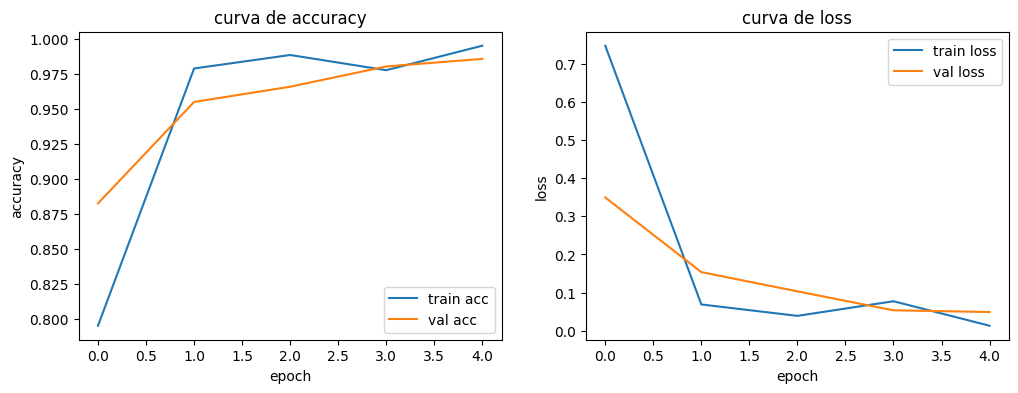

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

#accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.title("curva de accuracy")

#loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("curva de loss")

plt.show()


In [ ]:
y_true = [] #lista para guardar las etiquetas reales
y_pred = [] #lista para guardar las etiquetas predichas

for video, label in zip(test_videos, test_labels): #recorremos los videos y etiquetas de prueba
    frames = extract_frames(video) #extraemos los frames del video
    if frames is None: #verificamos si el video no es valido
        continue #saltamos al siguiente video

    preds = model.predict(frames, verbose=0) #obtenemos la prediccion por frame
    avg_pred = np.mean(preds, axis=0) #promediamos las predicciones de todos los frames
    pred_class = np.argmax(avg_pred) #obtenemos la clase con mayor probabilidad

    y_pred.append(pred_class) #guardamos la clase predicha
    y_true.append(le.transform([label])[0]) #guardamos la clase real codificada

print(classification_report( #mostramos el reporte de clasificacion
    y_true, #etiquetas reales
    y_pred, #etiquetas predichas
    target_names=le.classes_, #nombres de las clases
    zero_division=0 #evitamos divisiones entre cero
))


                  precision    recall  f1-score   support

   ApplyLipstick       0.94      1.00      0.97        15
BodyWeightSquats       1.00      1.00      1.00        14
     JumpingJack       1.00      1.00      1.00        16
    PlayingPiano       1.00      0.93      0.96        14
         PushUps       1.00      1.00      1.00        13

        accuracy                           0.99        72
       macro avg       0.99      0.99      0.99        72
    weighted avg       0.99      0.99      0.99        72



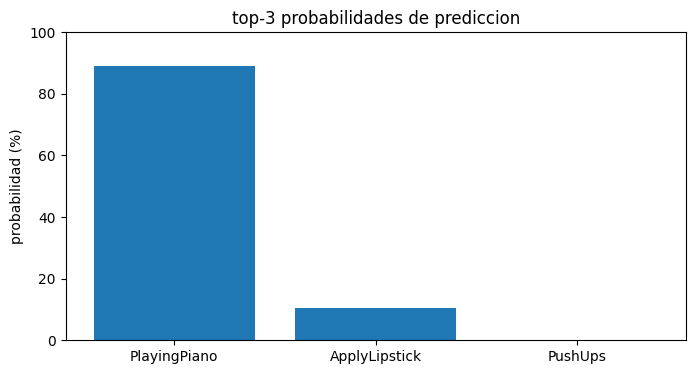

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import HTML, display #importamos herramientas para mostrar html en el notebook
from base64 import b64encode #importamos b64encode para codificar el video en base64

#seleccionar video aleatorio
video_path = random.choice(test_videos)
true_label = os.path.basename(os.path.dirname(video_path))

#prediccion
frames = extract_frames(video_path) #extraemos los frames del video seleccionado
preds = model.predict(frames, verbose=0) #obtenemos la prediccion del modelo para cada frame
avg_pred = np.mean(preds, axis=0) #promediamos las predicciones para obtener una sola por video

pred_idx = np.argmax(avg_pred) #obtenemos el indice de la clase con mayor probabilidad
pred_label = le.classes_[pred_idx] #obtenemos el nombre de la clase predicha
confidence = avg_pred[pred_idx] * 100 #calculamos el porcentaje de confianza de la prediccion

#top 3 predicciones
top3_idx = np.argsort(avg_pred)[-3:][::-1] #obtenemos los indices de las tres clases mas probables
top3_labels = le.classes_[top3_idx] #obtenemos los nombres de las tres clases principales
top3_probs = avg_pred[top3_idx] * 100 #obtenemos las probabilidades en porcentaje

#resultado correcto o no
correct = (true_label == pred_label) #verificamos si la prediccion coincide con la clase real
color = "green" if correct else "red" #asignamos color verde si es correcta o rojo si no

#bloque de info
display(HTML(f""" #mostramos un bloque html con la informacion de la prediccion
<div style="font-family: Arial; padding: 10px;">
  <h2 style="color:{color};">Resultado de la predicción</h2>
  <p><b>Clase real:</b> {true_label}</p>
  <p><b>Clase predicha:</b> {pred_label}</p>
  <p><b>Confianza:</b> {confidence:.2f}%</p>
  <h4>Top-3 predicciones</h4>
  <ul>
    <li>{top3_labels[0]} — {top3_probs[0]:.2f}%</li>
    <li>{top3_labels[1]} — {top3_probs[1]:.2f}%</li>
    <li>{top3_labels[2]} — {top3_probs[2]:.2f}%</li>
  </ul>
</div>
"""))

#grafica de probabilidades
plt.figure(figsize=(8,4)) #definimos el tamaño de la figura
plt.bar(top3_labels, top3_probs) #graficamos las probabilidades de las top 3 clases
plt.ylabel("probabilidad (%)") #etiquetamos el eje y
plt.title("top-3 probabilidades de prediccion") #titulo de la grafica
plt.ylim(0,100) #limitamos el eje y de 0 a 100
plt.show() #mostramos la grafica

#convertir avi a mp4
mp4_path = "/content/temp.mp4" #definimos la ruta temporal del video mp4
os.system(f"ffmpeg -loglevel quiet -y -i '{video_path}' '{mp4_path}'") #convertimos el video avi a mp4 usando ffmpeg

mp4 = open(mp4_path, "rb").read() #leemos el archivo mp4 en modo binario
data_url = "data:video/mp4;base64," + b64encode(mp4).decode() #codificamos el video en base64

display(HTML(f""" #mostramos el video directamente en el notebook
<video width="420" controls style="border:2px solid {color}; border-radius:8px;">
  <source src="{data_url}" type="video/mp4">
</video>
"""))
